In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
from keras.models import load_model
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import tensorflow as tf
from tensorflow.python.client import device_lib
import matplotlib.patches as mpatches
from scipy import signal



/home/sam/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
print("----------------------------")
print
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17132148769575131281
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11275639194
locality {
  bus_id: 1
}
incarnation: 18294776726622805833
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
----------------------------

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6256693373675497556
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 355336192
locality {
  bus_id: 1
}
incarnation: 2669969478470983420
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# TODO:
* Record trials in an organized excel sheet, or write out each one to a .txt file 
* 


## Generate sine wave data points

In [4]:
# #Define characteristics of the data to generate (square wave also has period 2PI)
num_cycles = 20
sample_rate = 0.1
points_per_cycle = int((2*np.pi) / sample_rate)

#Sample from a pure sine wave
data = [signal.square(i) for i in np.arange(start=0, stop=num_cycles*2*np.pi, step=sample_rate)]

print("Total data points: " + str(len(data)))




Total data points: 1257


## Data Formatting
* `series_to_examples`: Function to convert a 1D series into example data consisting of `X` and `Y` columns
* `prepare_data`: Function to prepare and split data into `train`/`test` sets

* NOTE: We can also add scaling in these functions, to squash values closer together


In [5]:
# Convert 1D series into example data of X and Y columns
def series_to_examples(series, n_prev=1, n_forecast=1, dropnan=True):
    """
    Transform time series data into supervised learning dataset.
    Arguments: 
        series: Sequence of observations as a list
        n_prev: Number of lag observations as input (X)
        n_forecast: Number of observations to predict (Y)
        dropnan: Boolean to drop rows with NaN values resulting from shift
    Returns:
        Pandas Dataframe
        
    Note: by this logic we should have N = (n_prev + n_forecast) columns
     and (series_len - N + 1) rows
    """
    
    #Robust check for whether or not series is univariate or multi-variate
    #If not a simple list (univariate), then the columns of shape will tell you how many variables
    num_dims = 1 if type(series) is list else series.shape[1]
    
    #convert the series to a dataframe format for shift
    df = pd.DataFrame(series)
    
    #Cols is a list of lists where each inner list is a whole column
    cols, names = list(), list()
    
    #Build each column of the input, first column will be fully shifted (i.e oldest example seen) 
    for i in range(n_prev, 0, -1):
        cols.append(df.shift(i))
        #names just a list??
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build each column of the output forecasts (t, t+1, ...)
    for i in range(0, n_forecast):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_dims)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build a final dataframe columns side by side & attach names
    final = pd.concat(cols, axis=1)
    final.columns = names

    
    #Remove all rows with NaN values
    if dropnan:
        final.dropna(inplace=True)
        
    print("in series_to_examples")
    print(final.shape)
        
    return final  



#Prepare and split data into train/test sets
def prepare_data(series, n_test, n_prev, n_forecast):#, batch_size):
    
    #Prepare data handles intital split!!!
    
    #NEW: Split before sending into series_to_examples
    train, test = series[:-n_test], series[-n_test:] 
    
    
    #TODO: Could scale here
    
    #Grab supervised-formatted data
    df_train = series_to_examples(train, n_prev, n_forecast)
    
    #Drop excess examples to allow for varying batch size
    #cutoff = int(len(df_train)/batch_size) * batch_size
    #df_train = df_train[:cutoff]
    
    print("in prepare_data")
    print(df_train.shape)
    #Extract and retain structure of values from dataframe
    example_values_train = df_train.values
    
    return example_values_train, test


## Define data structure to be passed to network

In [6]:
#Test size has to be large enough to encompass one full cycle

n_prev = points_per_cycle * 3
n_forecast = points_per_cycle


#The test data has to encompass both n_prev points and n_forecast points
#We feed the first n_prev points of the test into the network to make a prediction and compare this to n_forecast
#(This is just enough to predict one cycle)
n_test = n_prev + n_forecast


train, test = prepare_data(data, n_test, n_prev, n_forecast)#, batch_size)

print(n_forecast)

in series_to_examples
(762, 248)
in prepare_data
(762, 248)
62


## Visualize total dataset and goal in red

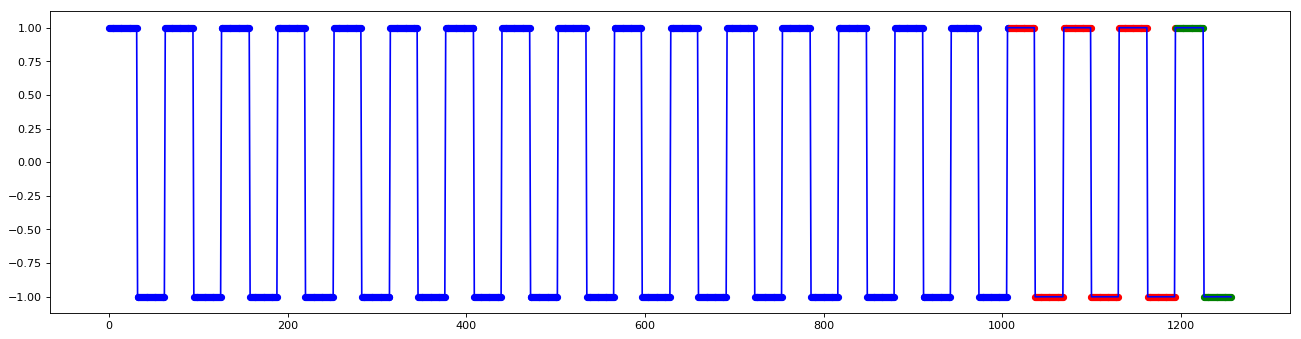

In [7]:
#Set the figure parameters
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#Grab the points for each section of the plot
train_points, test_input_points, test_label_points = data[:-n_test], data[-n_test:-n_forecast], data[-n_forecast:]

#Plot the training data and the underlying curve in blue 
plt.plot(data, color="blue")
train_plot_x = [x for x in range(len(train_points))]
plt.scatter(train_plot_x, train_points, color="blue", s=30)

#Plot the test example X in red
test_input_xs = [x +len(train_points) for x in range(len(test_input_points))]
plt.scatter(test_input_xs, test_input_points, color="red", s=30)





#Plot the test target label in green
test_label_xs = [x +(len(train_points)+len(test_input_points)) for x in range(len(test_label_points))]
plt.scatter(test_label_xs, test_label_points, color="green", s=30)











# #Plot the original data using the defined train and test sizes

# #Line plot along the true data
# plt.plot(data, color="blue")

# #Plot the training points in green
# train_plot_x = [x for x in range(len(train_plot))]
# plt.scatter(train_plot_x, train_plot, color="blue", s=30)

# #Note: we have to shift the test data to plot it
# test_plot_x = [x +len(train_plot) for x in range(len(test_plot))]
# plt.scatter(test_plot_x, test_plot, color="red", s=30)


## Define LSTM architecture

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [8]:
# # fit an LSTM network to training data
# def mae_percent(y_true, y_pred):
    
#     cycle_height = max(y_true) - min(y_true)

#     np.sum(abs(y_true-y_pred)
    
#     error_sum = 0
#     for i in range(len(test_y)):
#         error_sum += abs(test_y[i] - y_hat[i])
    
#     avg_error_sum = error_sum/len(test_y)
#     return (avg_error_sum/cycle_height)*100
    
    
    



def fit_lstm(train, n_prev, n_forecast, n_batch, nb_epoch, n_neurons):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    
    architecture = ""
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    X, y = train[:, 0:n_prev], train[:, n_prev:]

    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    #X = X.reshape(X.shape[0], 1, X.shape[1]) !!!!
    X = X.reshape(X.shape[0],X.shape[1],1)
    
    #y = y.reshape(1, y.shape[0])
    
    #print(y.shape[1])
    
    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    print((n_batch, X.shape[1], X.shape[2]))
    print(X.shape)
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    architecture += "LSTM; "
    model.add(Dense(180))
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    architecture += "Dense output; "
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy']) #Hod wants mean squared error
    
    
    
    
    #Fit the network to the training data
    history = model.fit(X, y, validation_split=0.2, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=False)

    
#     for i in range(nb_epoch):
#         print(i)
#         start = timer()
#         model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
#         model.reset_states()
#         end = timer()
#         print("Epoch duration: " + str(end - start))
    return model, architecture, history

In [9]:
print(train.shape)
train = train[12:]
print(train.shape)

(762, 248)
(750, 248)


## Train the Neural Network

In [10]:
n_epochs = 1500
n_batch = 150
n_neurons = 200
print(len(train))
print(train.shape)
#model, architecture = fit_lstm(train, n_prev, n_forecast, n_batch, n_epochs, n_neurons)
model, architecture,history = fit_lstm(train, n_prev, n_forecast, n_batch, n_epochs, n_neurons)


750
(750, 248)
X shape: (750, 186)
y shape: (750, 62)
(150, 186, 1)
(750, 186, 1)
Train on 600 samples, validate on 150 samples
Epoch 1/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.9731 - acc: 0.0000e+00 - val_loss: 0.8944 - val_acc: 0.0000e+00
Epoch 2/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.8182 - acc: 0.0000e+00 - val_loss: 0.6513 - val_acc: 0.0000e+00
Epoch 3/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.5470 - acc: 0.0000e+00 - val_loss: 0.4345 - val_acc: 0.0000e+00
Epoch 4/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.3674 - acc: 0.0000e+00 - val_loss: 0.2594 - val_acc: 0.0000e+00
Epoch 5/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.2454 - acc: 0.0000e+00 - val_loss: 0.2450 - val_acc: 0.0000e+00
Epoch 6/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.2368 - acc: 0.0000e+00 - val_loss: 0.2253 - val_acc: 0.0000e+00
Epoch 7/1500
600/600

600/600 [==============================] - 1s 2ms/step - loss: 0.0641 - acc: 0.0200 - val_loss: 0.0608 - val_acc: 0.0267
Epoch 61/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0600 - acc: 0.0233 - val_loss: 0.0606 - val_acc: 0.0267
Epoch 62/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0602 - acc: 0.0250 - val_loss: 0.0608 - val_acc: 0.0133
Epoch 63/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0622 - acc: 0.0233 - val_loss: 0.0597 - val_acc: 0.0133
Epoch 64/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0581 - acc: 0.0233 - val_loss: 0.0552 - val_acc: 0.0267
Epoch 65/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0602 - acc: 0.0267 - val_loss: 0.0560 - val_acc: 0.0267
Epoch 66/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0560 - acc: 0.0283 - val_loss: 0.0565 - val_acc: 0.0133
Epoch 67/1500
600/600 [==============================] - 1s 2ms/step 

600/600 [==============================] - 1s 2ms/step - loss: 0.0336 - acc: 0.0317 - val_loss: 0.0343 - val_acc: 0.0333
Epoch 181/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0342 - acc: 0.0283 - val_loss: 0.0365 - val_acc: 0.0333
Epoch 182/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0357 - acc: 0.0250 - val_loss: 0.0400 - val_acc: 0.0333
Epoch 183/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0377 - acc: 0.0200 - val_loss: 0.0444 - val_acc: 0.0200
Epoch 184/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0398 - acc: 0.0183 - val_loss: 0.0465 - val_acc: 0.0200
Epoch 185/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0411 - acc: 0.0200 - val_loss: 0.0418 - val_acc: 0.0200
Epoch 186/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0404 - acc: 0.0183 - val_loss: 0.0340 - val_acc: 0.0333
Epoch 187/1500
600/600 [==============================] - 1s 2m

600/600 [==============================] - 1s 2ms/step - loss: 0.0304 - acc: 0.0150 - val_loss: 0.0276 - val_acc: 0.0133
Epoch 299/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0286 - acc: 0.0150 - val_loss: 0.0276 - val_acc: 0.0000e+00
Epoch 300/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0277 - acc: 0.0150 - val_loss: 0.0268 - val_acc: 0.0067
Epoch 301/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0272 - acc: 0.0167 - val_loss: 0.0268 - val_acc: 0.0133
Epoch 302/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0274 - acc: 0.0200 - val_loss: 0.0278 - val_acc: 0.0133
Epoch 303/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0280 - acc: 0.0133 - val_loss: 0.0282 - val_acc: 0.0133
Epoch 304/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0284 - acc: 0.0117 - val_loss: 0.0283 - val_acc: 0.0133
Epoch 305/1500
600/600 [==============================] - 1

600/600 [==============================] - 1s 2ms/step - loss: 0.0302 - acc: 0.0550 - val_loss: 0.0347 - val_acc: 0.0133
Epoch 419/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0308 - acc: 0.0533 - val_loss: 0.0317 - val_acc: 0.0133
Epoch 420/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0307 - acc: 0.0317 - val_loss: 0.0273 - val_acc: 0.0133
Epoch 421/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0294 - acc: 0.0217 - val_loss: 0.0250 - val_acc: 0.0133
Epoch 422/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0271 - acc: 0.0167 - val_loss: 0.0254 - val_acc: 0.0133
Epoch 423/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0252 - acc: 0.0167 - val_loss: 0.0247 - val_acc: 0.0133
Epoch 424/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0242 - acc: 0.0167 - val_loss: 0.0239 - val_acc: 0.0133
Epoch 425/1500
600/600 [==============================] - 1s 2m

600/600 [==============================] - 1s 2ms/step - loss: 0.0264 - acc: 0.0517 - val_loss: 0.0302 - val_acc: 0.0133
Epoch 539/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0273 - acc: 0.0667 - val_loss: 0.0371 - val_acc: 0.0333
Epoch 540/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0297 - acc: 0.0733 - val_loss: 0.0346 - val_acc: 0.0400
Epoch 541/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0300 - acc: 0.0767 - val_loss: 0.0268 - val_acc: 0.0400
Epoch 542/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0280 - acc: 0.0433 - val_loss: 0.0239 - val_acc: 0.0000e+00
Epoch 543/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0242 - acc: 0.0233 - val_loss: 0.0232 - val_acc: 0.0000e+00
Epoch 544/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0223 - acc: 0.0250 - val_loss: 0.0223 - val_acc: 0.0000e+00
Epoch 545/1500
600/600 [===========================

600/600 [==============================] - 1s 2ms/step - loss: 0.0249 - acc: 0.0300 - val_loss: 0.0229 - val_acc: 0.0000e+00
Epoch 599/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0228 - acc: 0.0233 - val_loss: 0.0232 - val_acc: 0.0000e+00
Epoch 600/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0211 - acc: 0.0267 - val_loss: 0.0213 - val_acc: 0.0000e+00
Epoch 601/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0213 - acc: 0.0300 - val_loss: 0.0243 - val_acc: 0.0333
Epoch 602/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0234 - acc: 0.0500 - val_loss: 0.0296 - val_acc: 0.0333
Epoch 603/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0263 - acc: 0.0750 - val_loss: 0.0314 - val_acc: 0.0333
Epoch 604/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0272 - acc: 0.0767 - val_loss: 0.0284 - val_acc: 0.0333
Epoch 605/1500
600/600 [===========================

Epoch 658/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0228 - acc: 0.0567 - val_loss: 0.0216 - val_acc: 0.0000e+00
Epoch 659/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0218 - acc: 0.0300 - val_loss: 0.0239 - val_acc: 0.0533
Epoch 660/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0233 - acc: 0.0500 - val_loss: 0.0229 - val_acc: 0.0333
Epoch 661/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0228 - acc: 0.0383 - val_loss: 0.0225 - val_acc: 0.0000e+00
Epoch 662/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0216 - acc: 0.0367 - val_loss: 0.0217 - val_acc: 0.0000e+00
Epoch 663/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0211 - acc: 0.0317 - val_loss: 0.0216 - val_acc: 0.0000e+00
Epoch 664/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0210 - acc: 0.0317 - val_loss: 0.0219 - val_acc: 0.0000e+00
Epoch 665/1500
600/600 [====

600/600 [==============================] - 1s 2ms/step - loss: 0.0216 - acc: 0.0383 - val_loss: 0.0225 - val_acc: 0.0200
Epoch 718/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0218 - acc: 0.0383 - val_loss: 0.0229 - val_acc: 0.0200
Epoch 719/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0223 - acc: 0.0367 - val_loss: 0.0232 - val_acc: 0.0333
Epoch 720/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0230 - acc: 0.0467 - val_loss: 0.0247 - val_acc: 0.0333
Epoch 721/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0237 - acc: 0.0467 - val_loss: 0.0267 - val_acc: 0.0333
Epoch 722/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0251 - acc: 0.0550 - val_loss: 0.0288 - val_acc: 0.0333
Epoch 723/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0270 - acc: 0.0733 - val_loss: 0.0289 - val_acc: 0.0333
Epoch 724/1500
600/600 [==============================] - 1s 2m

600/600 [==============================] - 1s 2ms/step - loss: 0.0195 - acc: 0.0383 - val_loss: 0.0207 - val_acc: 0.0000e+00
Epoch 836/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0195 - acc: 0.0483 - val_loss: 0.0209 - val_acc: 0.0000e+00
Epoch 837/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0193 - acc: 0.0483 - val_loss: 0.0208 - val_acc: 0.0000e+00
Epoch 838/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0191 - acc: 0.0500 - val_loss: 0.0205 - val_acc: 0.0000e+00
Epoch 839/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0189 - acc: 0.0483 - val_loss: 0.0196 - val_acc: 0.0000e+00
Epoch 840/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0187 - acc: 0.0583 - val_loss: 0.0191 - val_acc: 0.0000e+00
Epoch 841/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0188 - acc: 0.0617 - val_loss: 0.0193 - val_acc: 0.0000e+00
Epoch 842/1500
600/600 [===========

600/600 [==============================] - 1s 2ms/step - loss: 0.0188 - acc: 0.0667 - val_loss: 0.0211 - val_acc: 0.0000e+00
Epoch 954/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0188 - acc: 0.0700 - val_loss: 0.0211 - val_acc: 0.0000e+00
Epoch 955/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0188 - acc: 0.0733 - val_loss: 0.0197 - val_acc: 0.0000e+00
Epoch 956/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0191 - acc: 0.0833 - val_loss: 0.0182 - val_acc: 0.0000e+00
Epoch 957/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0202 - acc: 0.0900 - val_loss: 0.0179 - val_acc: 0.0000e+00
Epoch 958/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0215 - acc: 0.1083 - val_loss: 0.0188 - val_acc: 0.0200
Epoch 959/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0221 - acc: 0.1233 - val_loss: 0.0208 - val_acc: 0.0200
Epoch 960/1500
600/600 [===================

600/600 [==============================] - 1s 2ms/step - loss: 0.0174 - acc: 0.1050 - val_loss: 0.0175 - val_acc: 0.0200
Epoch 1072/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0174 - acc: 0.1167 - val_loss: 0.0180 - val_acc: 0.0200
Epoch 1073/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0174 - acc: 0.1183 - val_loss: 0.0184 - val_acc: 0.0200
Epoch 1074/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0176 - acc: 0.1200 - val_loss: 0.0188 - val_acc: 0.0200
Epoch 1075/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0180 - acc: 0.1200 - val_loss: 0.0196 - val_acc: 0.0200
Epoch 1076/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0186 - acc: 0.1267 - val_loss: 0.0209 - val_acc: 0.0400
Epoch 1077/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0195 - acc: 0.1300 - val_loss: 0.0225 - val_acc: 0.0267
Epoch 1078/1500
600/600 [==============================] 

600/600 [==============================] - 1s 1ms/step - loss: 0.0257 - acc: 0.0650 - val_loss: 0.0311 - val_acc: 0.0000e+00
Epoch 1190/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0261 - acc: 0.0717 - val_loss: 0.0172 - val_acc: 0.0200
Epoch 1191/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0228 - acc: 0.1217 - val_loss: 0.0226 - val_acc: 0.0733
Epoch 1192/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0237 - acc: 0.1217 - val_loss: 0.0198 - val_acc: 0.0400
Epoch 1193/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0198 - acc: 0.1767 - val_loss: 0.0219 - val_acc: 0.0200
Epoch 1194/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0188 - acc: 0.1217 - val_loss: 0.0181 - val_acc: 0.0200
Epoch 1195/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0190 - acc: 0.1183 - val_loss: 0.0184 - val_acc: 0.0200
Epoch 1196/1500
600/600 [============================

600/600 [==============================] - 1s 1ms/step - loss: 0.0216 - acc: 0.1450 - val_loss: 0.0232 - val_acc: 0.0200
Epoch 1308/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0227 - acc: 0.1217 - val_loss: 0.0248 - val_acc: 0.0333
Epoch 1309/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0240 - acc: 0.1083 - val_loss: 0.0237 - val_acc: 0.0533
Epoch 1310/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0245 - acc: 0.0967 - val_loss: 0.0203 - val_acc: 0.0400
Epoch 1311/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0223 - acc: 0.1083 - val_loss: 0.0223 - val_acc: 0.0200
Epoch 1312/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0220 - acc: 0.0967 - val_loss: 0.0252 - val_acc: 0.0133
Epoch 1313/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0218 - acc: 0.0733 - val_loss: 0.0194 - val_acc: 0.0200
Epoch 1314/1500
600/600 [==============================] 

Epoch 1367/1500
600/600 [==============================] - 1s 1ms/step - loss: 0.0290 - acc: 0.0767 - val_loss: 0.0224 - val_acc: 0.0333
Epoch 1368/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0219 - acc: 0.1133 - val_loss: 0.0223 - val_acc: 0.0133
Epoch 1369/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0211 - acc: 0.0767 - val_loss: 0.0202 - val_acc: 0.0400
Epoch 1370/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0213 - acc: 0.1033 - val_loss: 0.0225 - val_acc: 0.0400
Epoch 1371/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0221 - acc: 0.1083 - val_loss: 0.0197 - val_acc: 0.0200
Epoch 1372/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0192 - acc: 0.1333 - val_loss: 0.0192 - val_acc: 0.0200
Epoch 1373/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0183 - acc: 0.1317 - val_loss: 0.0191 - val_acc: 0.0667
Epoch 1374/1500
600/600 [================

Epoch 1427/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0192 - acc: 0.1333 - val_loss: 0.0200 - val_acc: 0.0400
Epoch 1428/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0194 - acc: 0.1300 - val_loss: 0.0196 - val_acc: 0.0400
Epoch 1429/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0193 - acc: 0.1250 - val_loss: 0.0191 - val_acc: 0.0400
Epoch 1430/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0188 - acc: 0.1333 - val_loss: 0.0188 - val_acc: 0.0400
Epoch 1431/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0182 - acc: 0.1383 - val_loss: 0.0185 - val_acc: 0.0333
Epoch 1432/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0178 - acc: 0.1417 - val_loss: 0.0185 - val_acc: 0.0400
Epoch 1433/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0179 - acc: 0.1400 - val_loss: 0.0190 - val_acc: 0.0400
Epoch 1434/1500
600/600 [================

Epoch 1487/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0185 - acc: 0.1283 - val_loss: 0.0195 - val_acc: 0.0400
Epoch 1488/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0190 - acc: 0.1167 - val_loss: 0.0193 - val_acc: 0.0200
Epoch 1489/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0194 - acc: 0.1167 - val_loss: 0.0189 - val_acc: 0.0200
Epoch 1490/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0195 - acc: 0.1183 - val_loss: 0.0183 - val_acc: 0.0200
Epoch 1491/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0190 - acc: 0.1150 - val_loss: 0.0179 - val_acc: 0.0200
Epoch 1492/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0182 - acc: 0.1183 - val_loss: 0.0179 - val_acc: 0.0200
Epoch 1493/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0170 - acc: 0.1400 - val_loss: 0.0175 - val_acc: 0.0200
Epoch 1494/1500
600/600 [================

In [13]:
#Save model history
import pickle
with open('../training_histories/square_train_history_dict.pickle', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

AttributeError: 'dict' object has no attribute 'history'

In [15]:
name = '../training_histories/square_train_history_dict'
filename = open(name + ".pickle","rb")
history = pickle.load(filename)
filename.close() 

EOFError: 

['acc', 'loss', 'val_acc', 'val_loss']


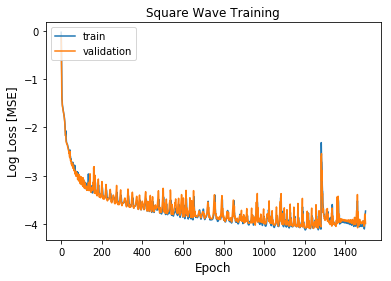

In [16]:
# list all data in history
print(history.keys())
# summarize history for accuracy
# plt.plot(history.history['mean_absolute_error'])
# plt.plot(history.history['val_mean_absolute_error'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(np.log(history['loss']))
plt.plot(np.log(history['val_loss']))
plt.title('Square Wave Training')
plt.ylabel('Log Loss [MSE]', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [1]:
from keras.models import load_model
model.save('../checkpoints/squareLSTM_1500epoch_200neuron_180dense.h5')
#model.save('loadtime_3000epoch_100batch_200neuron_180dense_div2point3.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('loadtime_200epoch_200batch_200neuron_180dense.h5')

/home/sam/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


NameError: name 'model' is not defined

In [26]:
from keras.utils import plot_model
plot_model(model, to_file='../assets/lstm_architecture_triangle.png')

In [47]:
def forecast_lstm(model, X, n_batch):
    
    Xs = [X for _ in range(n_batch)]
    
    x_stack = np.stack((Xs))
    print(x_stack.shape)
    
    X = x_stack.reshape(n_batch,len(X),1)
    
    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]

In [48]:
#Run on test data
test_x, test_y = test[0:n_prev], test[n_prev:]
test_x = np.array(test_x)
y_hat = forecast_lstm(model, test_x, n_batch)
avg_RMSE = math.sqrt(mean_squared_error(test_y, y_hat))

print("Average RMSE: " + str(avg_RMSE))

(150, 186)
Average RMSE: 0.0611355323629


## Mean Absolute Error (MAE) accuracy on the Validation Data, as percentage of maximum value

In [49]:
#This should be using the "height" of the wave
max_height = max(test_y) - min(test_y)
# print(max(test_y))
# print(min(test_y))
# print(max_height)

error_sum = 0
for i in range(len(test_y)):
    error_sum += abs(test_y[i] - y_hat[i])
    
avg_error_sum = error_sum/len(test_y)
mean_abs_error_percentage = (avg_error_sum/max_height)*100
print("mean_abs_error_percentage: "+str(mean_abs_error_percentage))

mean_abs_error_percentage: 1.1917286342190156


mean_abs_error_percentage: 1.1407432058832507


## Display Results
* Blue: Sample used for prediction
* Green: What we are trying to predict
* Red: Actual prediction

Epochs: 1500
Average RMSE: 0.0611355323629
mean_abs_error_percentage: 1.1917286342190156
Average predicted value: -0.007219385716222947
Variance of predicted values: 0.9853093
Min: -1.06299 Max: 1.0849483


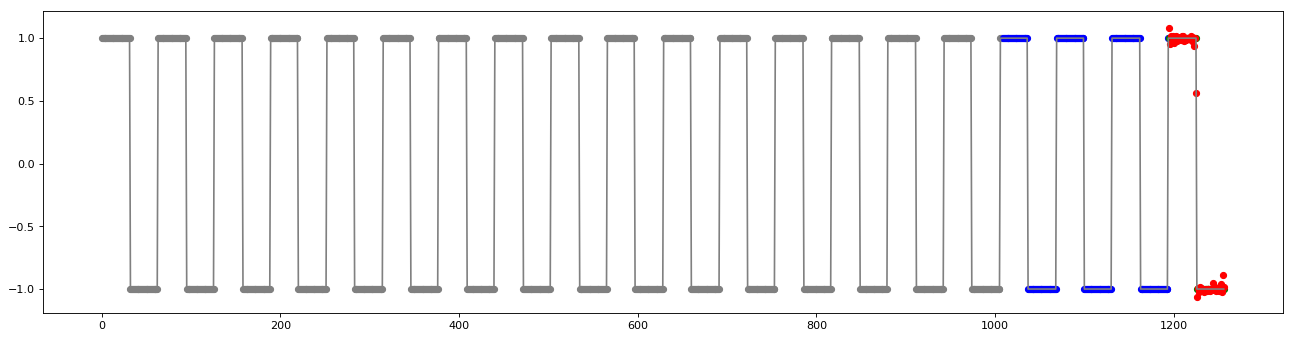

In [50]:
#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#Training data in Blue
plt.plot(data, color="gray")
train_plot_x = [x for x in range(len(train_points))]
plt.scatter(train_plot_x, train_points, color="gray", s=30)

#Display the input (X) for the prediction purple
test_x_start = len(data) - n_test
test_x_end = len(data) - len(y_hat)

test_x_indices = [x for x in range(test_x_start, test_x_end)]
test_x_labels = [data[y] for y in test_x_indices]

plt.scatter(test_x_indices, test_x_labels, color="blue", s=30)


#Define indices for which to plot the prediction
index_start = test_x_end
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]


#Display true labels in green
true_labels = [data[y] for y in range(index_start, index_end)]
plt.scatter(labels_x, true_labels, color="green", s=30)

#Display forecasted labels in red
plt.scatter(labels_x, y_hat, color="red", s=30)



gray_patch = mpatches.Patch(color='gray', label='Training/Validation data')

blue_patch = mpatches.Patch(color='blue', label='Test input example(X)')

green_patch = mpatches.Patch(color='green', label='True labels (Y)')

red_patch = mpatches.Patch(color='red', label='Forecast (Y-hat)')

#plt.legend(handles=[gray_patch, blue_patch, green_patch, red_patch],bbox_to_anchor=(1.04,1), loc="upper left")



# from matplotlib.font_manager import FontProperties

# fontP = FontProperties()
# fontP.set_size('large')
# plt.legend([red_patch], "dfdfd", prop=fontP)

#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")




print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(avg_RMSE))
print("mean_abs_error_percentage: "+str(mean_abs_error_percentage))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))